## Limpeza, Tratamento de Valores, Exploração e Visualização dos Dados

In [73]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, recall_score
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler

In [74]:
df = pd.read_csv('data/train.csv')
print(df.describe())
print(df.head())

       track_unique_id   duration_ms  danceability        energy  \
count     79800.000000  7.980000e+04  79800.000000  79800.000000   
mean      57140.494048  2.279022e+05      0.567318      0.641529   
std       32993.196225  1.050599e+05      0.173110      0.251441   
min           0.000000  1.338600e+04      0.000000      0.000019   
25%       28450.500000  1.744360e+05      0.456000      0.472000   
50%       57234.000000  2.128130e+05      0.581000      0.685000   
75%       85774.250000  2.614260e+05      0.695000      0.854000   
max      113998.000000  5.237295e+06      0.985000      1.000000   

                key      loudness          mode   speechiness  acousticness  \
count  79800.000000  79800.000000  79800.000000  79800.000000  79800.000000   
mean       5.307043     -8.263741      0.637732      0.084750      0.314979   
std        3.562186      5.035504      0.480659      0.105657      0.332512   
min        0.000000    -49.307000      0.000000      0.000000      0.00

In [75]:
#limpeza
le = LabelEncoder()

df['artists_encoded'] = le.fit_transform(df['artists'])
df['album_name_encoded'] = le.fit_transform(df['album_name'])
df['track_genre_encoded'] = le.fit_transform(df['track_genre'])

df_limpo = df.drop(['artists', 'album_name', 'track_genre', 'track_name'], axis=1)

print(df_limpo.head())

   track_unique_id                track_id  duration_ms  explicit  \
0            41996  7hUhmkALyQ8SX9mJs5XI3D       211533     False   
1            76471  5x59U89ZnjZXuNAAlc8X1u       196000     False   
2            54809  70Vng5jLzoJLmeLu3ayBQq       216506     False   
3            16326  1cRfzLJapgtwJ61xszs37b       218346     False   
4           109799  47d5lYjbiMy0EdMRV8lRou       173160     False   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.305  0.8490    9   -10.795     1       0.0549      0.000058   
1         0.287  0.1900    7   -12.030     0       0.0370      0.930000   
2         0.583  0.5090    1    -9.661     1       0.0362      0.777000   
3         0.163  0.0368    8   -23.149     1       0.0472      0.991000   
4         0.647  0.9210    2    -7.294     1       0.1850      0.000939   

   instrumentalness  liveness  valence    tempo  time_signature  \
0          0.056700    0.4640   0.3200  141.793               4   


In [76]:
df_limpo.isnull().sum()



track_unique_id        0
track_id               0
duration_ms            0
explicit               0
danceability           0
energy                 0
key                    0
loudness               0
mode                   0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
tempo                  0
time_signature         0
popularity_target      0
artists_encoded        0
album_name_encoded     0
track_genre_encoded    0
dtype: int64

In [77]:
# Verificar se há linhas duplicadas
duplicated_rows = df_limpo.duplicated()

# Contar quantas linhas duplicadas existem
num_duplicated_rows = duplicated_rows.sum()

print(f"Linhas duplicadas: {num_duplicated_rows}")

# Exibir as linhas duplicadas, se houver
df_duplicated = df[duplicated_rows]
df_duplicated

Linhas duplicadas: 0


,track_unique_id,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target,artists_encoded,album_name_encoded,track_genre_encoded


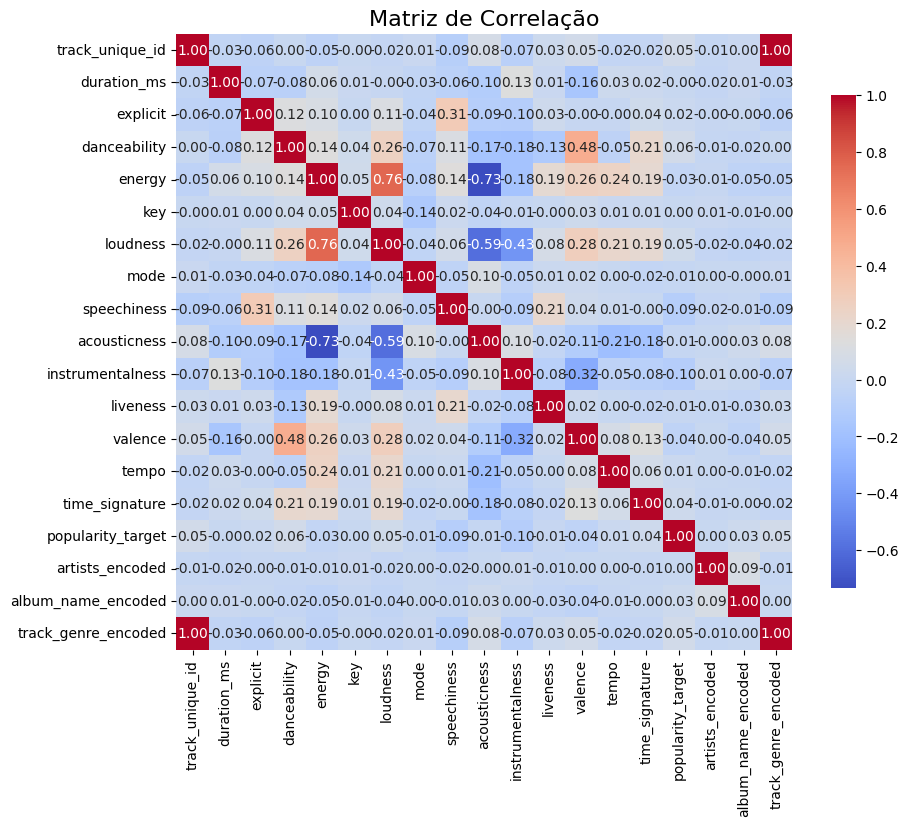

In [78]:
# Calcula a matriz de correlação
correlation_matrix = (df_limpo.drop(['track_id'], axis=1)).corr()

# Configura o tamanho da figura
plt.figure(figsize=(10, 8))

# Cria o heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Configura os rótulos e título
plt.title('Matriz de Correlação', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Mostra o gráfico
plt.show()

In [79]:
# Identificação de outliers usando o método IQR
outliers = {}
for column in df_limpo.select_dtypes(include=['float64', 'int64']):  # Apenas colunas numéricas
    Q1 = df_limpo[column].quantile(0.25)
    Q3 = df_limpo[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[column] = df_limpo[(df_limpo[column] < lower_bound) | (df_limpo[column] > upper_bound)][column]

# Mostrando o número de outliers por coluna
outliers_count = {column: len(outliers[column]) for column in outliers if not outliers[column].empty}
print(outliers_count)
print(df_limpo.head())

{'duration_ms': 3990, 'danceability': 420, 'loudness': 4351, 'speechiness': 9277, 'instrumentalness': 17645, 'liveness': 6032, 'tempo': 424, 'time_signature': 8598}
   track_unique_id                track_id  duration_ms  explicit  \
0            41996  7hUhmkALyQ8SX9mJs5XI3D       211533     False   
1            76471  5x59U89ZnjZXuNAAlc8X1u       196000     False   
2            54809  70Vng5jLzoJLmeLu3ayBQq       216506     False   
3            16326  1cRfzLJapgtwJ61xszs37b       218346     False   
4           109799  47d5lYjbiMy0EdMRV8lRou       173160     False   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.305  0.8490    9   -10.795     1       0.0549      0.000058   
1         0.287  0.1900    7   -12.030     0       0.0370      0.930000   
2         0.583  0.5090    1    -9.661     1       0.0362      0.777000   
3         0.163  0.0368    8   -23.149     1       0.0472      0.991000   
4         0.647  0.9210    2    -7.294     1 

In [80]:
# Colunas que possuem outliers
columns_with_outliers = ['duration_ms', 'danceability', 'loudness', 'speechiness', 
                         'instrumentalness', 'liveness', 'tempo', 'time_signature']

# Normalização das colunas com outliers
scaler = MinMaxScaler()
df_limpo[columns_with_outliers] = scaler.fit_transform(df_limpo[columns_with_outliers])

# Verificar os primeiros registros após a normalização
df_limpo.head()

,track_unique_id,track_id,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity_target,artists_encoded,album_name_encoded,track_genre_encoded
0,41996,7hUhmkALyQ8SX9mJs5XI3D,0.037931,False,0.309645,0.8490,9,0.715318,1,0.056891,0.000058,0.056700,0.4640,0.3200,0.636971,0.8,0,13481,18054,41
1,76471,5x59U89ZnjZXuNAAlc8X1u,0.034957,False,0.291371,0.1900,7,0.692379,0,0.038342,0.930000,0.000356,0.0834,0.1330,0.375935,0.8,0,7754,10815,76
2,54809,70Vng5jLzoJLmeLu3ayBQq,0.038883,False,0.591878,0.5090,1,0.736381,1,0.037513,0.777000,0.202000,0.1150,0.5440,0.406366,0.6,1,21526,28726,54
3,16326,1cRfzLJapgtwJ61xszs37b,0.039235,False,0.165482,0.0368,8,0.485856,1,0.048912,0.991000,0.899000,0.1070,0.0387,0.311952,0.6,0,8029,24834,16
4,109799,47d5lYjbiMy0EdMRV8lRou,0.030585,False,0.656853,0.9210,2,0.780345,1,0.191710,0.000939,0.371000,0.1310,0.1710,0.619847,0.8,0,20008,26251,109


In [81]:
df_limpo['duration_minutes'] = df_limpo['duration_ms'] / 60000
print(df_limpo.describe())

       track_unique_id   duration_ms  danceability        energy  \
count     79800.000000  79800.000000  79800.000000  79800.000000   
mean      57140.494048      0.041064      0.575958      0.641529   
std       32993.196225      0.020111      0.175746      0.251441   
min           0.000000      0.000000      0.000000      0.000019   
25%       28450.500000      0.030829      0.462944      0.472000   
50%       57234.000000      0.038176      0.589848      0.685000   
75%       85774.250000      0.047482      0.705584      0.854000   
max      113998.000000      1.000000      1.000000      1.000000   

                key      loudness          mode   speechiness  acousticness  \
count  79800.000000  79800.000000  79800.000000  79800.000000  79800.000000   
mean       5.307043      0.762333      0.637732      0.087824      0.314979   
std        3.562186      0.093529      0.480659      0.109489      0.332512   
min        0.000000      0.000000      0.000000      0.000000      0.00

## Hipoteses

### 1. Hipótese: Músicas de artistas que possuem músicas já populares tendem a ser populares
Justificativa: Artistas que já têm músicas populares podem ter uma base de fãs leal, o que aumenta a chance de suas novas músicas também se tornarem populares.

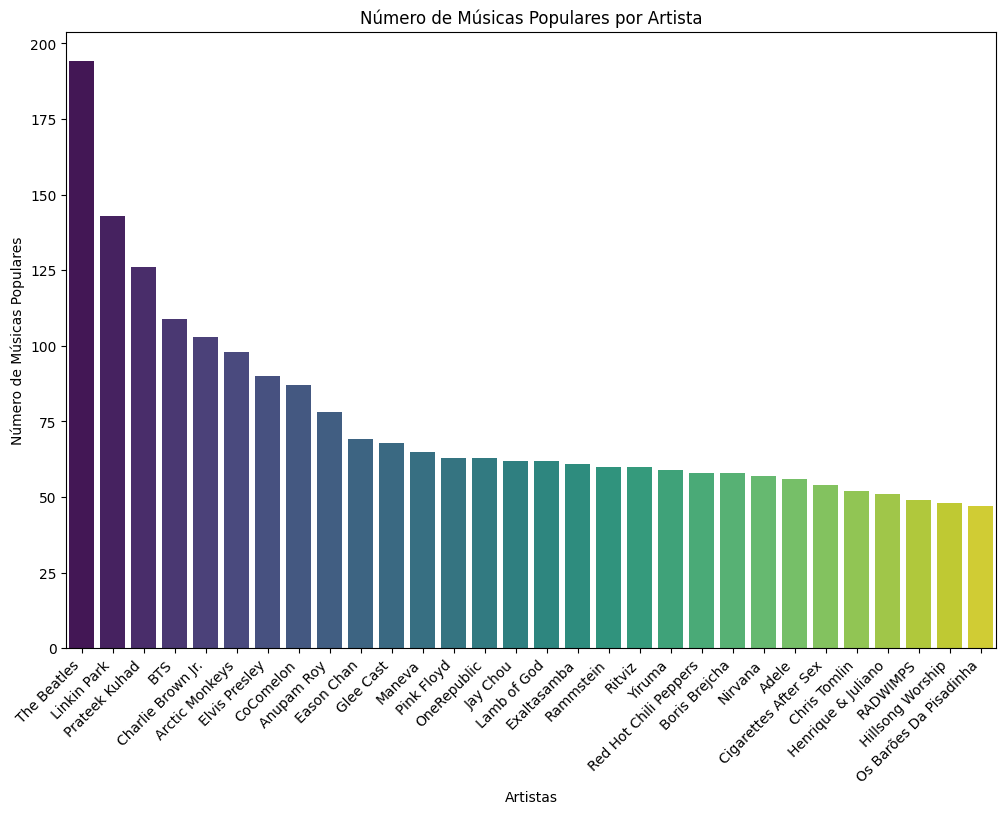

Quantidade de músicas populares dos The Beatles: 194


In [82]:
# Filtrar as músicas populares
popular_music = df[df['popularity_target'] == 1]

# Contar o número de músicas populares por artista e ordenar do maior para o menor
artist_popularity_count = popular_music['artists'].value_counts().reset_index()
artist_popularity_count.columns = ['artists', 'popular_songs_count']

# Ordenar do maior para o menor
artist_popularity_count = artist_popularity_count.sort_values(by='popular_songs_count', ascending=False)

# Configurar o gráfico
plt.figure(figsize=(12, 8))
sns.barplot(x='artists', y='popular_songs_count', data=artist_popularity_count.head(30), hue='artists', palette='viridis', legend=False)

# Adicionar títulos e rótulos
plt.title('Número de Músicas Populares por Artista')
plt.xlabel('Artistas')                        # Eixo X: Artistas
plt.ylabel('Número de Músicas Populares')     # Eixo Y: Número de Músicas Populares

# Rotacionar os nomes dos artistas para evitar sobreposição
plt.xticks(rotation=45, ha='right')

# Exibir o gráfico
plt.show()

beatles_music = df[df['artists'] == 'The Beatles']

# Contar e imprimir a quantidade de músicas populares (assumindo que 'popularity_target' é 1 para músicas populares)
num_popular_beatles = beatles_music[beatles_music['popularity_target'] == 1].shape[0]

print(f'Quantidade de músicas populares dos The Beatles: {num_popular_beatles}')

#### Conclusão:
Várias bandas, como The Beatles, que possuem um grande número de músicas populares, têm um valor próximo de um quando dividimos a quantidade de músicas populares pelo total de músicas da banda, confirmando a hipótese 1

### 2. Hipótese: A duração da música impacta sua popularidade
Justificativa: Músicas muito curtas ou muito longas podem influenciar a experiência de escuta. Músicas dentro de uma faixa de duração ideal podem ter maior chance de se tornarem populares.

C:\Users\felip\AppData\Local\Temp\ipykernel_22412\2265698564.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_popularity = df.groupby('duration_binned')['popularity_target'].mean()


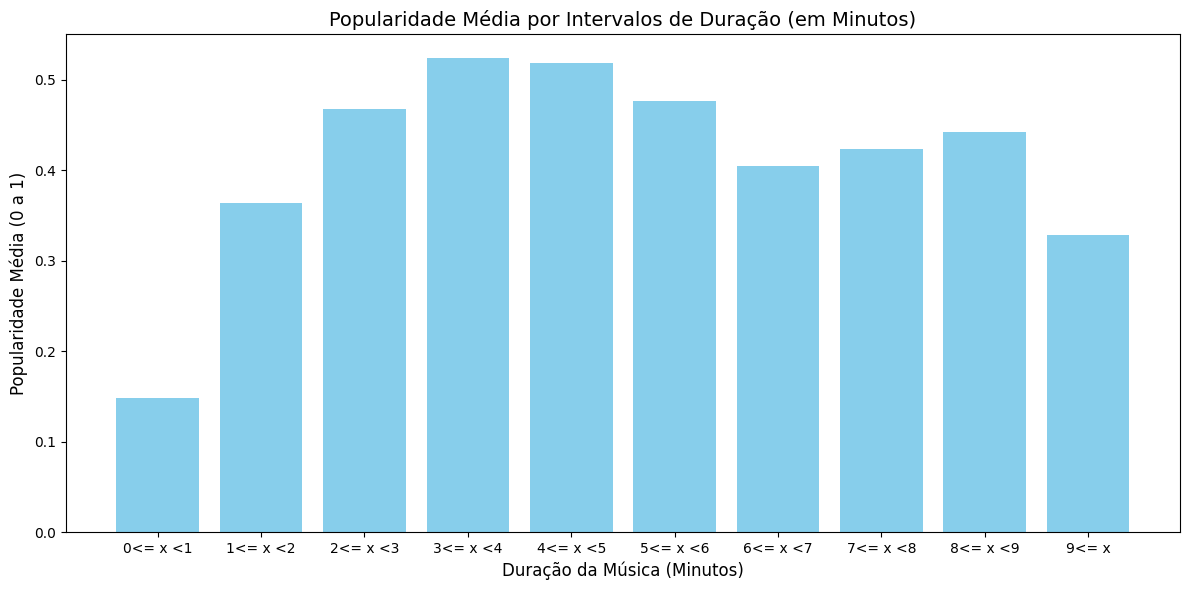

In [83]:
# Agrupar músicas por intervalos de duração em minutos
# Aqui agrupamos a duração em intervalos inteiros (1, 2, 3, etc.)
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, np.inf] 
labels = ['0<= x <1', '1<= x <2', '2<= x <3', '3<= x <4', '4<= x <5', '5<= x <6', '6<= x <7', '7<= x <8', '8<= x <9', '9<= x']  # Rótulos para os intervalos 

df['duration_minutes'] = df['duration_ms'] / 60000
# Agrupar músicas por intervalos de duração em minutos
df['duration_binned'] = pd.cut(df['duration_minutes'], bins=bins, labels=labels, right=False)

# Calcular a popularidade média em cada intervalo de duração
duration_popularity = df.groupby('duration_binned')['popularity_target'].mean()

# Configurar o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(duration_popularity.index.astype(str), duration_popularity, color='skyblue')

# Adicionar títulos e rótulos
plt.title('Popularidade Média por Intervalos de Duração (em Minutos)', fontsize=14)
plt.xlabel('Duração da Música (Minutos)', fontsize=12)
plt.ylabel('Popularidade Média (0 a 1)', fontsize=12)

# Exibir o gráfico
plt.tight_layout()
plt.show()

#### Conclusão:
Músicas que têm entre dois e seis minutos têm uma maior chance de serem populares, confirmando a hipótese 2



### 3. Hipótese: Alguns gêneros têm um maior número de músicas populares
Justificativa: Certos gêneros musicais podem ser mais atrativos para um público amplo, aumentando a probabilidade de as músicas desses gêneros se tornarem populares.

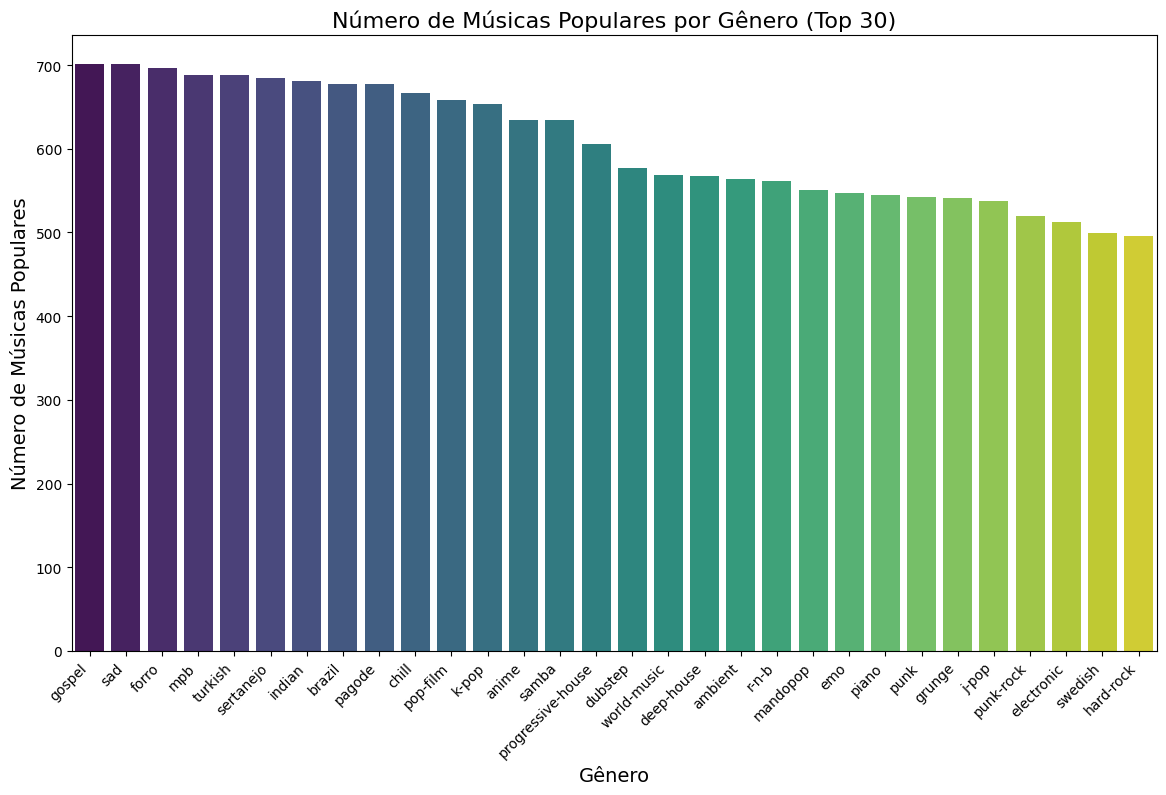

In [84]:
# Filtrar músicas populares (popularity_target = 1)
popular_music_by_genre = df[df['popularity_target'] == 1].groupby('track_genre_encoded').size().reset_index(name='count')

# Adicionar os nomes dos gêneros para visualização
popular_music_by_genre['genre'] = le.inverse_transform(popular_music_by_genre['track_genre_encoded'])

# Filtrar apenas os 30 gêneros mais populares
top_30_genres = popular_music_by_genre.nlargest(30, 'count')

# Criar o gráfico
plt.figure(figsize=(14, 8))  # Aumentar o tamanho da figura
sns.barplot(x='genre', y='count', data=top_30_genres.sort_values(by='count', ascending=False), palette='viridis', hue='genre', legend=False,  width=0.8)
plt.title('Número de Músicas Populares por Gênero (Top 30)', fontsize=16)
plt.xlabel('Gênero', fontsize=14)
plt.ylabel('Número de Músicas Populares', fontsize=14)

# Rotacionar os nomes dos gêneros para evitar sobreposição
plt.xticks(rotation=45, ha='right', fontsize=10)

plt.show()

#### Conclusão:
Gêneros como gospel, sad, forró e outros possuem mais de 600 músicas populares cada, o que fornece um forte indício que confirma a hipótese 3

## Seleção de Features, Construção e Avaliação do Modelo

In [85]:
print(df_limpo.head())

   track_unique_id                track_id  duration_ms  explicit  \
0            41996  7hUhmkALyQ8SX9mJs5XI3D     0.037931     False   
1            76471  5x59U89ZnjZXuNAAlc8X1u     0.034957     False   
2            54809  70Vng5jLzoJLmeLu3ayBQq     0.038883     False   
3            16326  1cRfzLJapgtwJ61xszs37b     0.039235     False   
4           109799  47d5lYjbiMy0EdMRV8lRou     0.030585     False   

   danceability  energy  key  loudness  mode  speechiness  ...  \
0      0.309645  0.8490    9  0.715318     1     0.056891  ...   
1      0.291371  0.1900    7  0.692379     0     0.038342  ...   
2      0.591878  0.5090    1  0.736381     1     0.037513  ...   
3      0.165482  0.0368    8  0.485856     1     0.048912  ...   
4      0.656853  0.9210    2  0.780345     1     0.191710  ...   

   instrumentalness  liveness  valence     tempo  time_signature  \
0          0.056700    0.4640   0.3200  0.636971             0.8   
1          0.000356    0.0834   0.1330  0.375935    

In [87]:
# Separar as features e o target
X = df_limpo.drop(['popularity_target', 'track_id'], axis=1)  # Usando as features específicas
y = df_limpo['popularity_target']  # Target

# Número desejado de linhas no conjunto de teste
n_test = 34200

# Calculando a fração do conjunto de teste
test_size = n_test / len(df_limpo)

# Dividindo o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Verificando o tamanho do conjunto de teste
print("Número de linhas em X_test:", X_test.shape[0])
print("Número de linhas em y_test:", y_test.shape[0])

# Definindo o modelo base (sem hiperparâmetros)
rf_model_base = RandomForestClassifier(random_state=42)

# Treinando o modelo base
rf_model_base.fit(X_train, y_train)

# Avaliando o modelo
accuracy = rf_model_base.score(X_test, y_test)
print("Acurácia do modelo base:", accuracy)

Número de linhas em X_test: 34200
Número de linhas em y_test: 34200
Acurácia do modelo base: 0.8279239766081872


Acurácia no Conjunto de Teste: 0.8279239766081872
Recall: 0.8160201753332532
ROC AUC: 0.9081209578620911


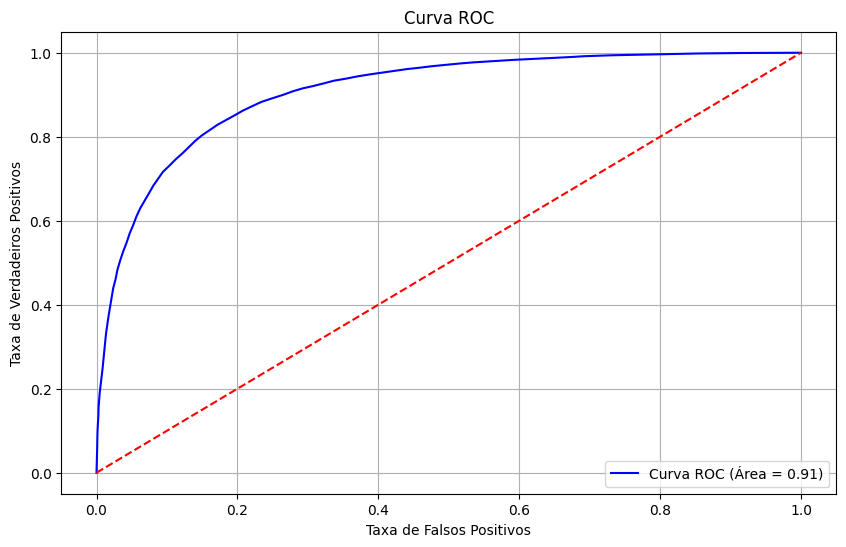

In [88]:
# Avaliando o modelo no conjunto de teste
y_pred = rf_model_base.predict(X_test)
y_prob = rf_model_base.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva

# Cálculo das métricas
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Imprimindo as métricas
print("Acurácia no Conjunto de Teste:", accuracy)
print("Recall:", recall)
print("ROC AUC:", roc_auc)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (Área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.grid()
plt.show()

essa cedula está comentada por conta do hiperparâmetro não mudar muito a acurácia

In [60]:
# # Definindo o grid de hiperparâmetros para RandomizedSearch
# param_dist = {
#     'max_depth': randint(10, 50),                        # Distribuição de profundidade da árvore
#     'min_samples_split': randint(2, 10),                 # Mínimo de amostras para dividir um nó
#     'min_samples_leaf': randint(1, 4),                   # Mínimo de amostras por folha
#     'n_estimators': randint(100, 500),                   # Número de árvores na floresta
#     'max_features': ['sqrt', 'log2', None],              # Número de features a considerar
#     'bootstrap': [True, False]                           # Método de amostragem
# }

# # Realizando RandomizedSearch para otimizar os hiperparâmetros
# random_search = RandomizedSearchCV(estimator=rf_model_base, param_distributions=param_dist,
#                                    scoring='accuracy', cv=3, verbose=2, n_jobs=-1, 
#                                    n_iter=50, random_state=42)  # 'n_iter' controla o número de combinações testadas

# # Treinando o modelo com RandomizedSearch
# random_search.fit(X_train, y_train)

# # Melhor conjunto de hiperparâmetros
# best_params = random_search.best_params_
# print("Melhores hiperparâmetros encontrados:", best_params)

# # Melhor modelo com os hiperparâmetros ajustados
# best_model = random_search.best_estimator_

# # Avaliando o modelo otimizado
# accuracy = best_model.score(X_test, y_test)
# print("Acurácia do modelo com hiperparâmetros otimizados:", accuracy)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Melhores hiperparâmetros encontrados: {'bootstrap': True, 'max_depth': 26, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 229}
Acurácia do modelo com hiperparâmetros otimizados: 0.846140350877193


Acurácia no Conjunto de Teste: 0.846140350877193
Recall: 0.8381169688963612
ROC AUC: 0.9219639919613727


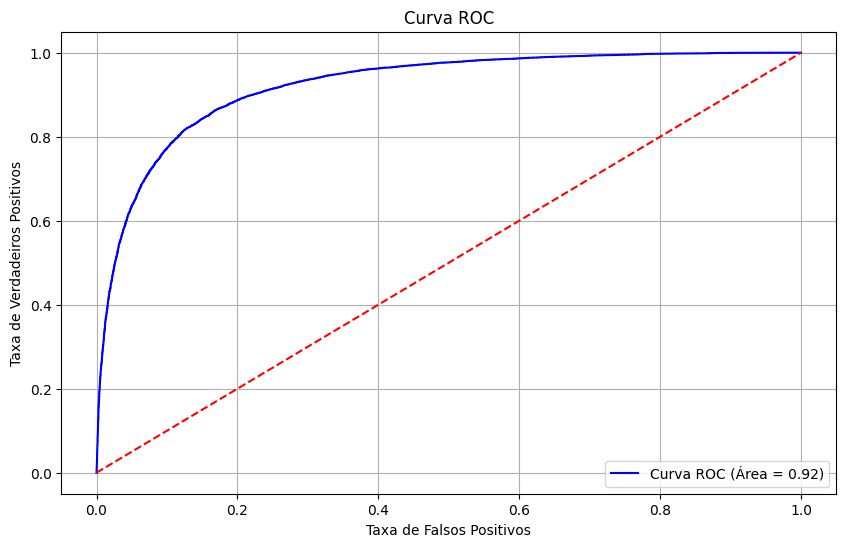

In [61]:
# # Avaliando o modelo no conjunto de teste
# y_pred = best_model.predict(X_test)
# y_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva

# # Cálculo das métricas
# accuracy = accuracy_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_prob)

# # Imprimindo as métricas
# print("Acurácia no Conjunto de Teste:", accuracy)
# print("Recall:", recall)
# print("ROC AUC:", roc_auc)

# # Curva ROC
# fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# plt.figure(figsize=(10, 6))
# plt.plot(fpr, tpr, color='blue', label='Curva ROC (Área = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='red', linestyle='--')
# plt.title('Curva ROC')
# plt.xlabel('Taxa de Falsos Positivos')
# plt.ylabel('Taxa de Verdadeiros Positivos')
# plt.legend(loc='lower right')
# plt.grid()
# plt.show()

In [89]:
print(df_limpo.head())

   track_unique_id                track_id  duration_ms  explicit  \
0            41996  7hUhmkALyQ8SX9mJs5XI3D     0.037931     False   
1            76471  5x59U89ZnjZXuNAAlc8X1u     0.034957     False   
2            54809  70Vng5jLzoJLmeLu3ayBQq     0.038883     False   
3            16326  1cRfzLJapgtwJ61xszs37b     0.039235     False   
4           109799  47d5lYjbiMy0EdMRV8lRou     0.030585     False   

   danceability  energy  key  loudness  mode  speechiness  ...  \
0      0.309645  0.8490    9  0.715318     1     0.056891  ...   
1      0.291371  0.1900    7  0.692379     0     0.038342  ...   
2      0.591878  0.5090    1  0.736381     1     0.037513  ...   
3      0.165482  0.0368    8  0.485856     1     0.048912  ...   
4      0.656853  0.9210    2  0.780345     1     0.191710  ...   

   instrumentalness  liveness  valence     tempo  time_signature  \
0          0.056700    0.4640   0.3200  0.636971             0.8   
1          0.000356    0.0834   0.1330  0.375935    

In [90]:
# Primeiro, adicione a coluna 'popularity_target' ao DataFrame de teste
test_results = X_test.copy()
test_results['popularity_target'] = y_test.values

# Agora, vamos adicionar a coluna de IDs do conjunto original 'df_limpo'
test_results['track_unique_id'] = df_limpo.loc[X_test.index, 'track_id'].values

# Selecionando apenas as colunas 'track_unique_id' e 'popularity_target'
output = test_results[['track_unique_id', 'popularity_target']]

# Salvando em um arquivo CSV
output.to_csv('test.csv', index=False)